### Merging Weight with filings

In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

In [333]:
# Load updated 10-K, existing 10-Q and 8-K files
df_10k = pd.read_csv("Data/aggregated_sentiment_scores_10K_new.csv")
df_10q = pd.read_csv("Data/aggregated_sentiment_scores_10Q.csv")
df_8k  = pd.read_csv("Data/aggregated_sentiment_scores_8K.csv")
weights = pd.read_csv("Data/updated/sp500_cik_weights_2007_2013.csv")

In [334]:
weights['Year'] = weights['Date'].astype(int)

In [335]:
# Parse dates and define week start
df_10k['Filing Date'] = pd.to_datetime(df_10k['Filing Date'])
df_10q['Filing Date'] = pd.to_datetime(df_10q['Filing Date'])
df_8k['Filing Date']  = pd.to_datetime(df_8k['Filing Date'])

In [336]:
for df in [df_10k, df_10q, df_8k]:
    df['Week'] = pd.to_datetime(df['Filing Date'].dt.to_period('W').apply(lambda r: r.end_time).dt.date)
    df['Year'] = df['Week'].dt.year

In [337]:
df_10k.head(), df_10k.shape

(       CIK  Type Filing Date  Section  Sentiment Score Sentiment Label  \
 0  1000697  10-K  2007-03-01  item_1A         0.999054        positive   
 1  1000697  10-K  2007-03-01   item_7        -0.324787        negative   
 2  1000697  10-K  2008-02-29  item_1A         0.985981        positive   
 3  1000697  10-K  2008-02-29   item_7        -0.298994        negative   
 4  1000697  10-K  2009-02-27  item_1A         0.992333        positive   
 
         Week  Year  
 0 2007-03-04  2007  
 1 2007-03-04  2007  
 2 2008-03-02  2008  
 3 2008-03-02  2008  
 4 2009-03-01  2009  ,
 (4610, 8))

In [338]:
weights.head()

,Ticker,Date,Weight,CIK,Year
0,A,2007,0.000962,1090872.0,2007
1,AAPL,2007,0.006146,320193.0,2007
2,ABT,2007,0.004116,1800.0,2007
3,ADBE,2007,0.002835,796343.0,2007
4,ADI,2007,0.001614,6281.0,2007


In [339]:
df_10k_old = df_10k.copy()
df_10q_old = df_10q.copy()
df_8k_old = df_8k.copy()

In [340]:
# 1) put your existing DFs into a list
dfs = [df_10k, df_10q, df_8k]

# 2) do the inner‑merge on each
dfs = [
    df.merge(weights[['CIK','Year','Weight']], on=['CIK','Year'], how='inner')
    for df in dfs
]

# 3) unpack them back to your original names
df_10k, df_10q, df_8k = dfs

In [341]:
df_10k[(df_10k['Year'] == 2009) & (df_10k['Section'] == 'item_7')]['Weight'].sum()

np.float64(0.8051891573346922)

In [342]:
# 10-K EDA: only Section 'item_7'
sec7 = df_10k[df_10k['Section'] == 'item_7'].copy()

# Calc weighted score
sec7['weighted_score'] = sec7['Sentiment Score'] * sec7['Weight']

weekly_10k = sec7.groupby('Week').agg(
    mean_sent=('Sentiment Score','mean'),
    count=('Sentiment Score','count'),
    total_wscore = ('weighted_score',   'sum')
).ffill().reset_index()

In [343]:
def week_fill(df):
    # make Week a DatetimeIndex and reindex over the full span
    df['Week'] = pd.to_datetime(df['Week'])
    df = df.set_index('Week')
    
    full_idx = pd.date_range(
        start=df.index.min(),
        end  =df.index.max(),
        freq ='W-SUN'                                                       # adjust weekday if needed
    )
    
    # 5) Reindex, ffill, reset
    df = (
        df
        .reindex(full_idx)    # will now insert missing weeks as NaN rows
        .ffill()              # carry last real values forward
        .reset_index()
        .rename(columns={'index':'Week'})
    )

    return df

In [344]:
# # Weekly Fill
# weekly_10k = week_fill(weekly_10k)

In [345]:
weekly_10k.shape

(239, 4)

In [346]:
# 10-Q EDA: two sections
sections = {
    'part_1_item_2': 'MD&A',
    'part_2_item_1A': 'Risk Factors'
}
# Calc weighted score
df_10q['weighted_score'] = df_10q['Sentiment Score'] * df_10q['Weight']

weekly_10q = {}
for code, name in sections.items():
    subset = df_10q[df_10q['Section'] == code]
    weekly_10q[name] = subset.groupby('Week').agg(
        mean_sent=('Sentiment Score','mean'),
        count=('Sentiment Score','count'),
        total_wscore = ('weighted_score',   'sum')
    ).ffill().reset_index()
    
    # # Weekly Fill
    # weekly_10q[name] = week_fill(weekly_10q[name])

In [347]:
# 8-K EDA: all sections combined
# Calc weighted score
df_8k['weighted_score'] = df_8k['Sentiment Score'] * df_8k['Weight']

weekly_8k = df_8k.groupby('Week').agg(
    mean_sent=('Sentiment Score','mean'),
    count=('Sentiment Score','count'),
    total_wscore = ('weighted_score',   'sum')
).ffill().reset_index()

# # Weekly Fill
# weekly_8k = week_fill(weekly_8k)

In [348]:
weekly_8k.head()

,Week,mean_sent,count,total_wscore
0,2007-01-07,-0.551072,25,-0.034294
1,2007-01-14,-0.422142,30,-0.014845
2,2007-01-21,-0.508291,56,-0.201355
3,2007-01-28,-0.764949,96,-0.271422
4,2007-02-04,-0.648797,105,-0.296764


## 10-K - Plots

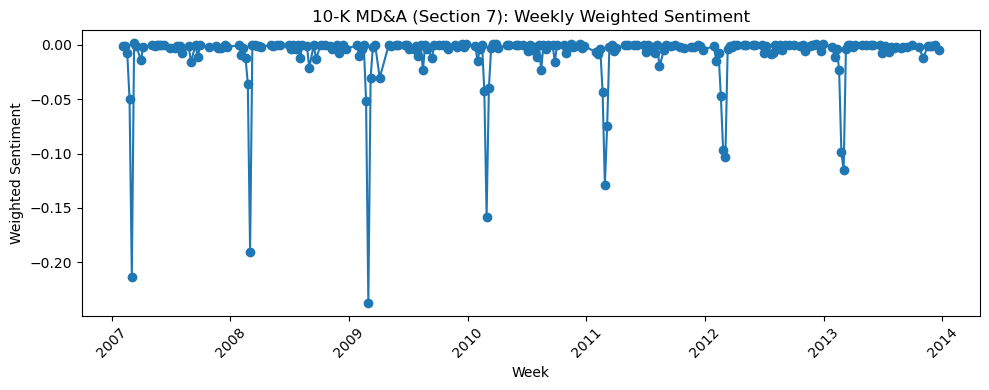

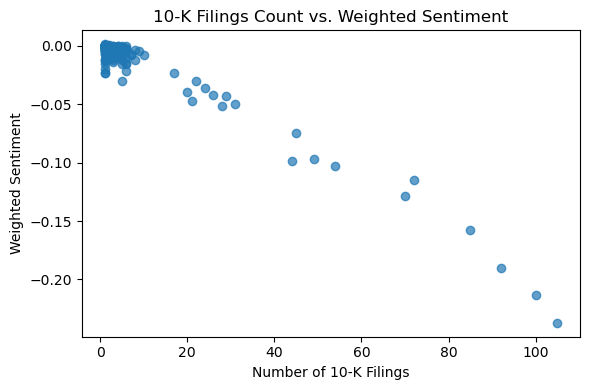

In [349]:
# Plotting
plt.figure(figsize=(10,4))
plt.plot(weekly_10k['Week'], weekly_10k['total_wscore'], marker='o')
plt.title("10-K MD&A (Section 7): Weekly Weighted Sentiment")
plt.xlabel("Week"); plt.ylabel("Weighted Sentiment")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.scatter(weekly_10k['count'], weekly_10k['total_wscore'], alpha=0.7)
plt.title("10-K Filings Count vs. Weighted Sentiment"); plt.xlabel("Number of 10-K Filings"); plt.ylabel("Weighted Sentiment")
plt.tight_layout(); plt.show()

## 10-Q plots

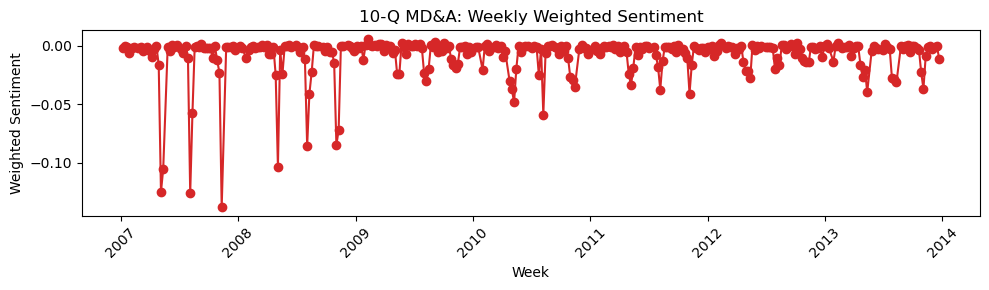

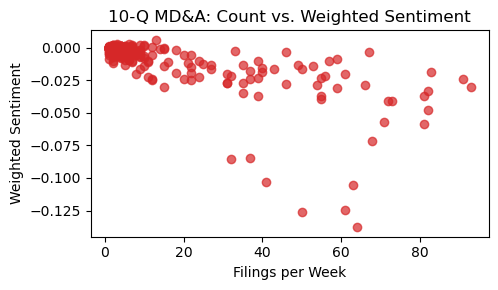

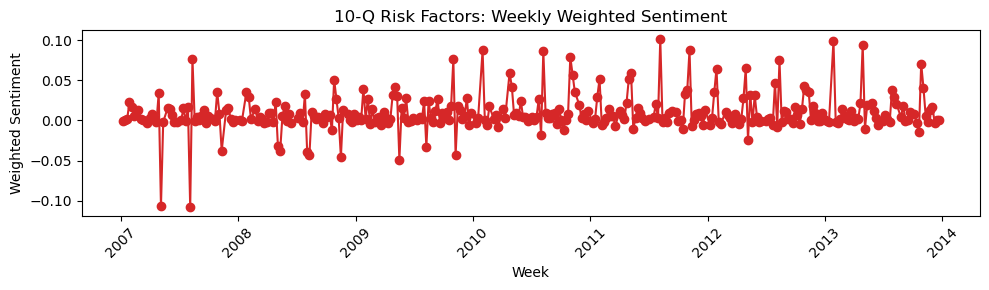

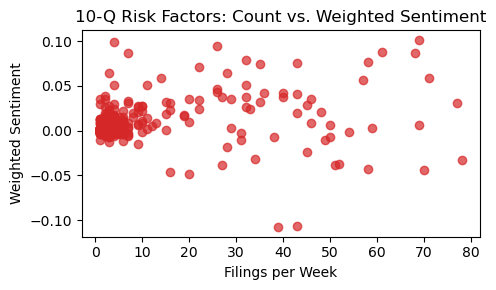

In [350]:
for name, weekly in weekly_10q.items():
    plt.figure(figsize=(10,3))
    plt.plot(weekly['Week'], weekly['total_wscore'], marker='o', color='C3')
    plt.title(f"10-Q {name}: Weekly Weighted Sentiment")
    plt.xlabel("Week"); plt.ylabel("Weighted Sentiment")
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()
    
    plt.figure(figsize=(5,3))
    plt.scatter(weekly['count'], weekly['total_wscore'], alpha=0.7, color='C3')
    plt.title(f"10-Q {name}: Count vs. Weighted Sentiment")
    plt.xlabel("Filings per Week"); plt.ylabel("Weighted Sentiment")
    plt.tight_layout(); plt.show()


## 8-K Plots

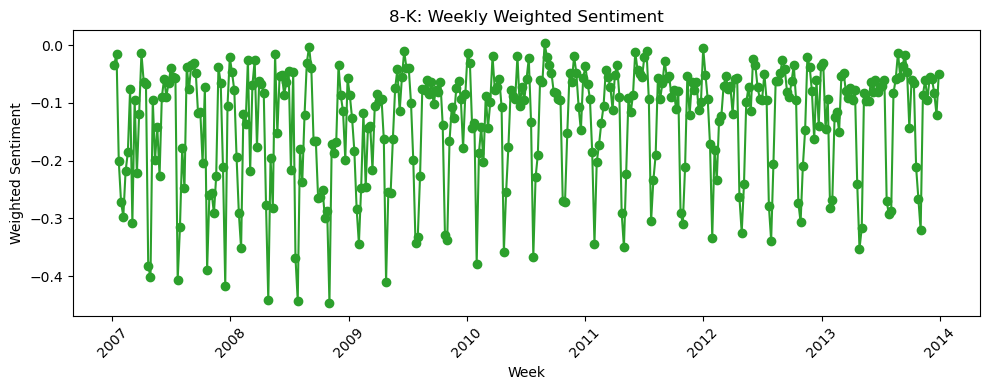

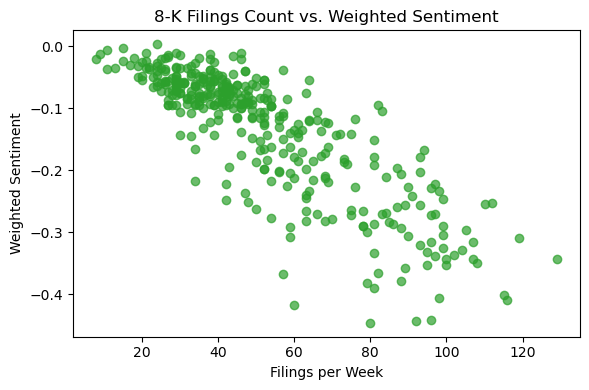

In [351]:
plt.figure(figsize=(10,4))
plt.plot(weekly_8k['Week'], weekly_8k['total_wscore'], marker='o', color='C2')
plt.title("8-K: Weekly Weighted Sentiment"); plt.xlabel("Week"); plt.ylabel("Weighted Sentiment")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.scatter(weekly_8k['count'], weekly_8k['total_wscore'], alpha=0.7, color='C2')
plt.title("8-K Filings Count vs. Weighted Sentiment"); plt.xlabel("Filings per Week"); plt.ylabel("Weighted Sentiment")
plt.tight_layout(); plt.show()

### Smoothing 10-Q

In [352]:
# Separate MD&A and Risk Factors sections
mda = df_10q[df_10q['Section'] == 'part_1_item_2']
risk = df_10q[df_10q['Section'] == 'part_2_item_1A']

In [353]:
# Compute weekly mean sentiment
weekly_mda = mda.groupby('Week')['Sentiment Score'].mean().rename('mda_sent')
weekly_risk = risk.groupby('Week')['Sentiment Score'].mean().rename('risk_sent')
# Compute weekly weighted sentiment
weekly_weighted_mda = mda.groupby('Week')['weighted_score'].sum().rename('mda_sent_weighted')
weekly_weighted_risk = risk.groupby('Week')['weighted_score'].sum().rename('risk_sent_weighted')

# Compute weekly count of 10‑Q rows
weekly_count = df_10q.groupby('Week').size().rename('count_10q')

In [354]:
# Combine into single DataFrame
weekly_10q = pd.concat([weekly_mda, weekly_risk, weekly_weighted_mda, weekly_weighted_risk, weekly_count], axis=1).sort_index().reset_index()

In [355]:
# Forward-fill missing weeks
# weekly_10q = week_fill(weekly_10q)

In [356]:
# Smooth each series with a 2-week rolling average
weekly_10q['mda_smoothed'] = weekly_10q['mda_sent'].rolling(2, min_periods=1).mean()
weekly_10q['risk_smoothed'] = weekly_10q['risk_sent'].rolling(2, min_periods=1).mean()
weekly_10q['mda_smoothed_weighted'] = weekly_10q['mda_sent_weighted'].rolling(2, min_periods=1).mean()
weekly_10q['risk_smoothed_weighted'] = weekly_10q['risk_sent_weighted'].rolling(2, min_periods=1).mean()

In [357]:
# Compute optimism vs. caution
weekly_10q['opt_vs_caut'] = weekly_10q['mda_smoothed'] - weekly_10q['risk_smoothed']
weekly_10q['opt_vs_caut_weighted'] = weekly_10q['mda_smoothed_weighted'] - weekly_10q['risk_smoothed_weighted']

In [358]:
weekly_10q.head()

,Week,mda_sent,risk_sent,mda_sent_weighted,risk_sent_weighted,count_10q,mda_smoothed,risk_smoothed,mda_smoothed_weighted,risk_smoothed_weighted,opt_vs_caut,opt_vs_caut_weighted
0,2007-01-07,-0.233253,-0.239603,-0.001677,-0.001268,9,-0.233253,-0.239603,-0.001677,-0.001268,0.006350,-0.000409
1,2007-01-14,0.074856,0.998194,0.000051,0.000674,2,-0.079198,0.379296,-0.000813,-0.000297,-0.458494,-0.000516
2,2007-01-21,-0.514279,0.982095,-0.001202,0.002296,2,-0.219711,0.990145,-0.000576,0.001485,-1.209856,-0.002061
3,2007-01-28,-0.252678,-0.256242,-0.006458,0.022924,6,-0.383478,0.362926,-0.003830,0.012610,-0.746405,-0.016440
4,2007-02-04,-0.121881,0.467867,-0.001874,0.016566,10,-0.187279,0.105812,-0.004166,0.019745,-0.293092,-0.023911


In [359]:
# Save outputs
weekly_10k.to_csv("Data/weekly_10k_weighted.csv", index=False)
weekly_10q.to_csv("Data/weekly_10q_weighted.csv", index=False)
weekly_8k.to_csv("Data/weekly_8k_weighted.csv", index=False)